# Вебинар 3. Коллаборативная фильтрация

### Домашняя работа №3

### 1. Базовое применение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k

In [2]:
data = pd.read_csv('data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
item_features = pd.read_csv('data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [4]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [9]:
%%time

model1 = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4, random_state=42)

model1.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs1 = model1.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 55.8 s
Wall time: 6.06 s


In [10]:
[id_to_itemid[rec[0]] for rec in recs1]

[5569230, 1106523, 999999, 1133018, 1082185]

In [11]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [12]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [13]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model1, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: total: 4min 31s
Wall time: 54.1 s


0.14696132596685085

In [14]:
result.head(2)

,user_id,actual,als
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1033142, 979707, 995242, 878996, 5569374]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1106523, 1133018, 951590, 5568378, 1092026]"


### Embeddings

In [16]:
model1.item_factors.shape

(5001, 100)

In [17]:
model1.user_factors.shape

(2500, 100)

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [18]:
fast_recs = model1.user_factors @ model1.item_factors.T 
fast_recs.shape

(2500, 5001)

In [19]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [20]:
model1.item_factors.shape

(5001, 100)

In [21]:
category = []

for idx in range(model1.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

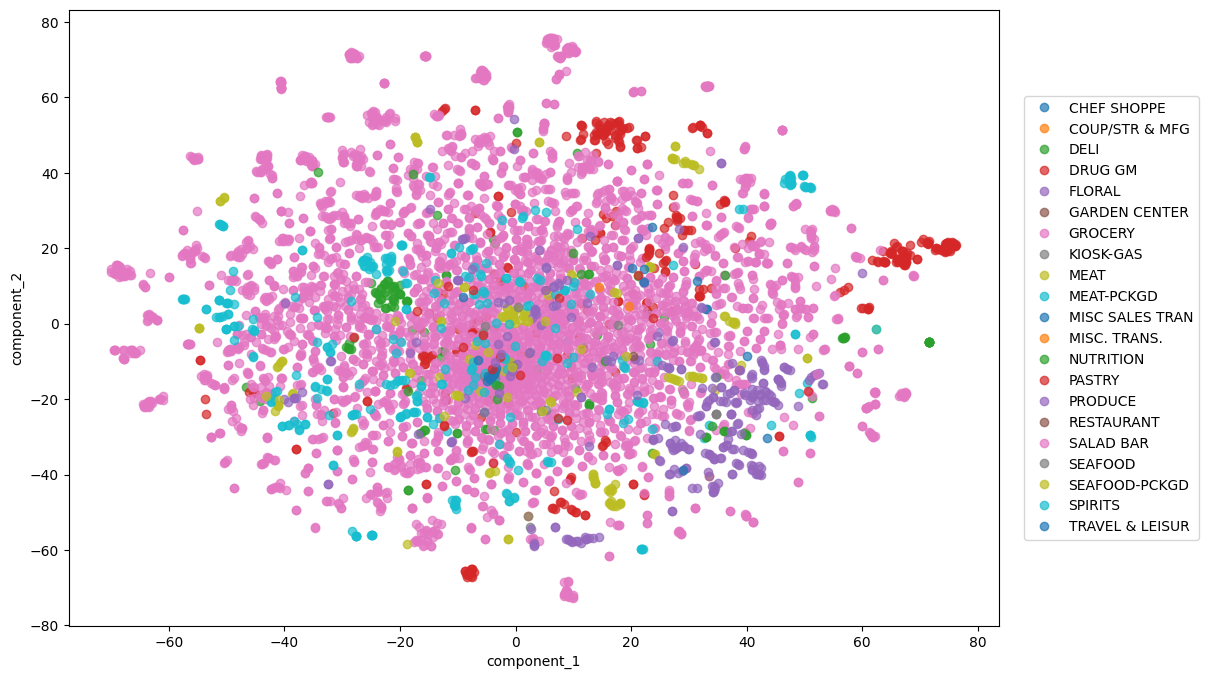

CPU times: total: 2min 47s
Wall time: 11.3 s


In [22]:
%%time
item_emb_tsne = reduce_dims(model1.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

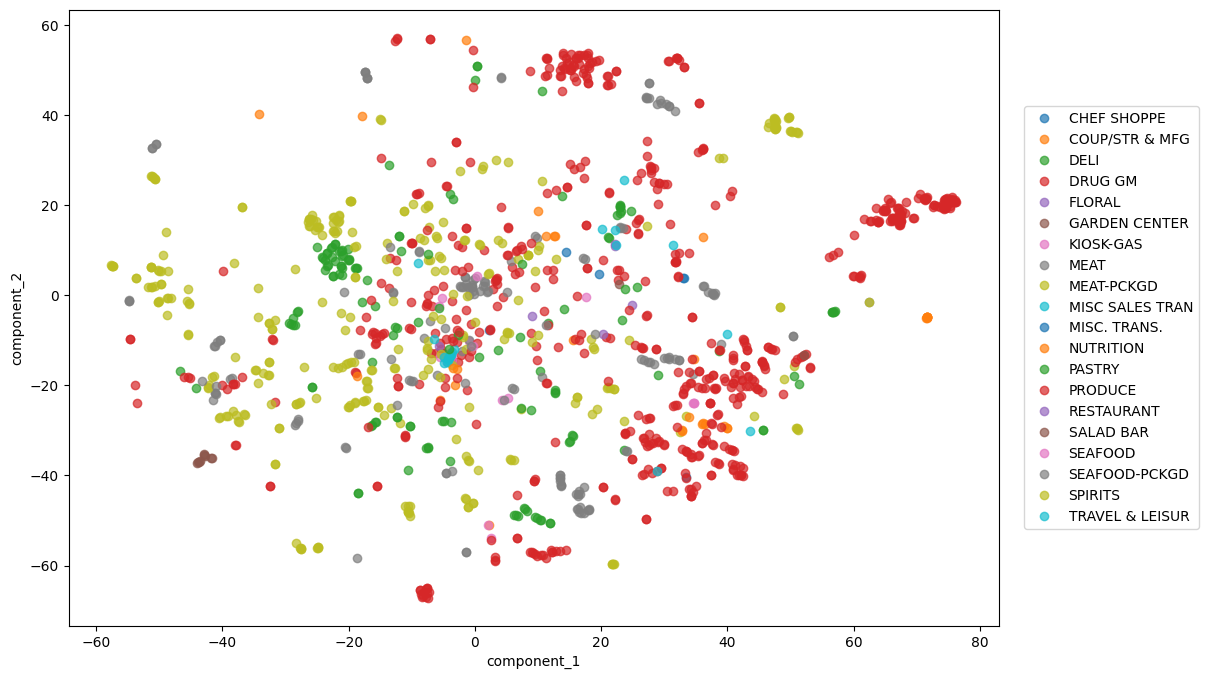

In [23]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

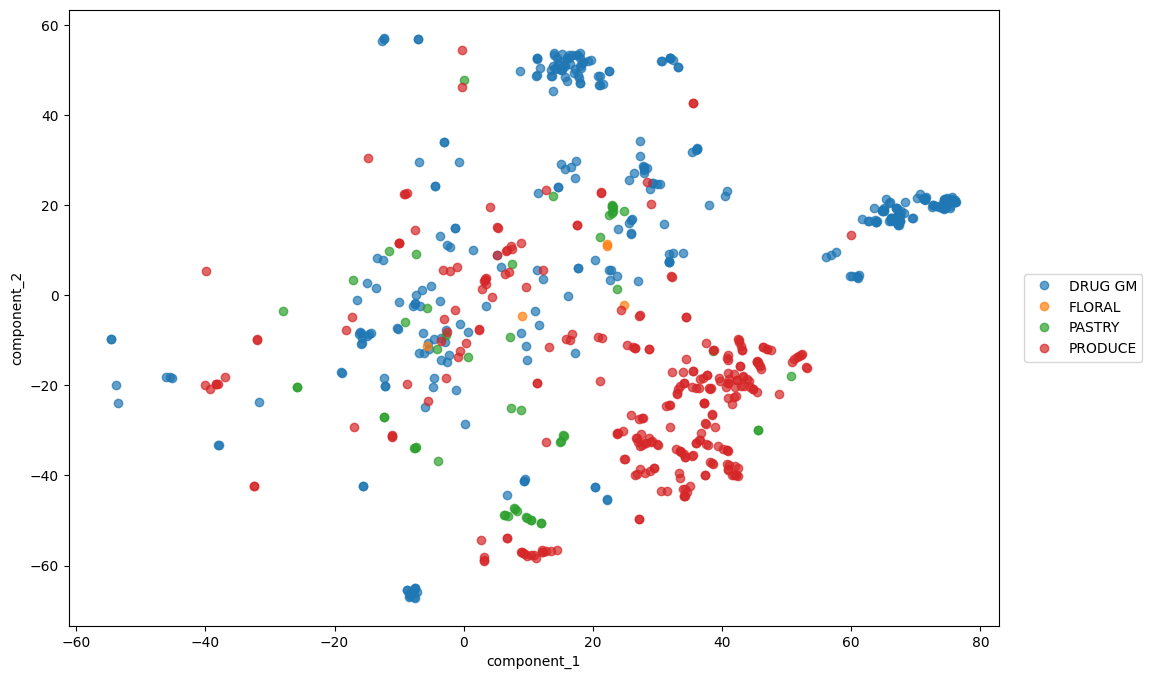

In [24]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [25]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-3.913773,-13.364684,MISC SALES TRAN
1,-5.507370,-13.736064,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [26]:
%%time
recommendations = model1.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2500 [00:00<?, ?it/s]

CPU times: total: 2min 10s
Wall time: 25.6 s


In [27]:
item_1 = model1.item_factors[1]
item_2 = model1.item_factors[2]

*Посмотрите также / Похожие товары*

In [28]:
model1.similar_items(1, N=5)

[(1, 1.0000001),
 (2, 0.8011452),
 (5, 0.7706193),
 (0, 0.75219023),
 (4, 0.7396575)]

*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [29]:
model1.similar_users(userid_to_id[10], N=5)

[(9, 0.9999999),
 (354, 0.973775),
 (790, 0.97070867),
 (1380, 0.97018117),
 (372, 0.9672473)]

### 2. TF-IDF взвешивание

In [30]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [31]:
%%time

model2 = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model2.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model2, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 3min 2s
Wall time: 32.5 s


0.14816675037669513

### 3. BM25 взвешивание

In [32]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [34]:
%%time

model3 = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model3.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 49.8 s
Wall time: 5.79 s


In [36]:
%%time

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model3, N=5))
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

CPU times: total: 5min
Wall time: 1min 6s


0.18663987945755903

In [37]:
result.to_csv('predictions/predictions_cf.csv', index=False)  # cf - collaborative filtering

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

In [45]:
result_n = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_n.columns=['user_id', 'actual']
result_n.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


#### Базовая модель

In [71]:
%%time

model1 = AlternatingLeastSquares(factors=200, 
                                regularization=0.1,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=4, random_state=42)

model1.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 16.9 s
Wall time: 2.3 s


In [72]:
%%time

result_n['als'] = result_n['user_id'].apply(lambda x: get_recommendations(x, model=model1, N=5))
result_n.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: total: 6min 7s
Wall time: 1min 6s


0.19869412355600202

0) Начальные параметры: factors=100, regularization=0.001, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42; result=0.18041
1) factors=100, regularization=0.01, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.18071320944249122
2) factors=100, regularization=0.1, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.18171772978402814
3) factors=150, regularization=0.1, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.1951783023606228, time: 1min
4) factors=200, regularization=0.1, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.19618282270215975, time: 1min 18s
5) factors=250, regularization=0.1, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.19015570065293824, time: 1min 53s
6) factors=250, regularization=0.01, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.18985434455047714, time: 1min 47s
7) factors=250, regularization=0.001, iterations=15, calculate_training_loss=True, num_threads=4, random_state=42, result=0.18854846810647916, time: 1min 42s
8) factors=250, regularization=0.001, iterations=10, calculate_training_loss=True, num_threads=4, random_state=42, result=0.18754394776494226, time: 1min 39s
9) factors=250, regularization=0.001, iterations=5, calculate_training_loss=True, num_threads=4, random_state=42, result=0.19347061778001007, time: 1min 36s
#### 10) factors=200, regularization=0.1, iterations=5, calculate_training_loss=True, num_threads=4, random_state=42, result=0.19869412355600202, time: 1min 7s

При подборе параметров выявлено, что при увеличении факторов, уменьшении коэф.регуляризации, уменьшении количества итерации, достигается высокий результат по нахождению метрики

#### TF-IDF взвешивание

In [79]:
%%time

model2 = AlternatingLeastSquares(factors=200, 
                                regularization=0.1,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=4)

model2.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 16.7 s
Wall time: 2.32 s


In [80]:
%%time

result_n['als_tfidf'] = result_n['user_id'].apply(lambda x: get_recommendations(x, model=model2, N=5))
result_n.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

CPU times: total: 6min 31s
Wall time: 1min 8s


0.20070316423907586

0) Начальные параметры: factors=100, regularization=0.001, iterations=15, calculate_training_loss=True, num_threads=4; result=0.14816675037669513, time: 
1) factors=200, regularization=0.001, iterations=15, calculate_training_loss=True, num_threads=4; result=0.1930688096433953, time: 1min 8s
2) factors=200, regularization=0.1, iterations=15, calculate_training_loss=True, num_threads=4; result=0.19387242591662482, time: 1min 7s
3) factors=200, regularization=0.1, iterations=5, calculate_training_loss=True, num_threads=4; result=0.20070316423907586, time: 1min 8s

Как видим, при аналогичных параметрах, найденных в базовой модели, здесь также достигается высокий результат метрики

#### BM25 взвешивание

In [87]:
%%time

model3 = AlternatingLeastSquares(factors=200, 
                                regularization=0.1,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model3.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 15.8 s
Wall time: 2.31 s


In [88]:
%%time

result_n['als_bm25'] = result_n['user_id'].apply(lambda x: get_recommendations(x, model=model3, N=5))
result_n.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

CPU times: total: 6min 54s
Wall time: 1min 11s


0.19949773982923155

0) Начальные параметры: factors=100, regularization=0.001, iterations=15, calculate_training_loss=True, num_threads=4; result=0.18141637368156707, time: 27.6 s
1) factors=200, regularization=0.001, iterations=15, calculate_training_loss=True, num_threads=4; result=0.19186338523355098, time: 1min 8s
2) factors=200, regularization=0.1, iterations=15, calculate_training_loss=True, num_threads=4; result=0.1943746860873933, time: 1min 10s
3) factors=200, regularization=0.1, iterations=5, calculate_training_loss=True, num_threads=4; result=0.19949773982923155, time: 1min 11s

Как ожидалось, при аналогичных параметрах, найденных в базовой модели, здесь также достигается высокий результат метрики

In [90]:
result_n.head(5)

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[999999, 1082185, 995242, 1033142, 934369]","[999999, 1082185, 995242, 9527290, 856942]","[999999, 15926844, 995242, 1082185, 965766]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1133018, 999999, 1092026, 965766, 883404]","[1133018, 999999, 1092026, 1106523, 908531]","[1133018, 999999, 1092026, 9337581, 1022003]"
2,5,"[913077, 1118028, 1386668]","[999999, 1082185, 1058997, 981760, 840361]","[999999, 1082185, 981760, 1126899, 1133018]","[999999, 1082185, 1058997, 1126899, 981760]"
3,6,"[825541, 859676, 999318, 1055646, 1067606, 108...","[866211, 1023720, 1082185, 999999, 878996]","[866211, 1082185, 878996, 1033220, 999999]","[878996, 1082185, 1023720, 1024306, 1127179]"
4,7,"[929248, 948622, 1013572, 1022003, 1049892, 10...","[999999, 1082185, 849843, 1058997, 1126899]","[999999, 1082185, 828867, 1126899, 1122358]","[999999, 1082185, 1122358, 893018, 1071939]"
